# Virtualization and OpenShift Workflow Agent

## Overview

This notebook demonstrates how to build an AI-powered multi-agent workflow that interacts with **Virtual Machines (VMs)** and **OpenShift**. The agents process tasks such as listing VMs, retrieving VM details, and managing OpenShift migration plans using custom tools. 

By leveraging a machine learning model, the agents are able to process natural language instructions and execute specific tasks. The workflow is designed to be flexible, allowing different agents to collaborate through a shared state, with task data being persisted using **SQLite**.

## 1. Setup

Before we begin, let's make sure your environment is set up correctly. We'll start by installing the necessary Python packages.

### Installing Required Packages

To get started, you'll need to install a few Python libraries. Run the following command to install them:

In [1]:
%pip install langchain langchain_community langgraph langgraph-checkpoint-sqlite requests termcolor

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U --no-cache-dir  \
                --config-settings="--global-option=build_ext" \
                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
                pygraphviz

Note: you may need to restart the kernel to use updated packages.


## 2. Configuring a Simple Model

In this section, we configure the machine learning model that we will use to process tasks. The `ModelService` class manages the interaction with the model (in this case, "llama3.1:8b-instruct-fp16").

### Model Configuration

We initialize the `ModelService` with a specific model configuration, including parameters such as model endpoint, temperature (for controlling randomness), and others. This step enables us to perform model-based tasks using the provided configuration.

In [3]:
from services.model_service import ModelService

# Initialize the service with the model configuration
ollama_service = ModelService(model="llama3.1:8b-instruct-fp16")

## 3. Defining the Shared State

In any multi-agent system, it’s crucial that agents can share information and coordinate their tasks. To achieve this, we use a **shared state** — a centralized data structure that agents read from and update as they perform their respective tasks. This shared state acts as a "memory" that persists between agent actions, enabling collaboration across different stages of the workflow.

In [4]:
from langgraph.graph.message import add_messages
from typing import Annotated, List, TypedDict, Any
from tasks.task import Task

class MultiAgentGraphState(TypedDict):
    tasks: List[dict]


class AgentOutputState(TypedDict):
    response: dict


class UpdateInputState(MultiAgentGraphState, AgentOutputState):
    pass

## 4. Setting Up Tools for the Workflow

In this section, we prepare the tools that will be used by the different agents in our workflow. Each agent has a specific set of tools they use to perform their tasks. Tools can represent any reusable function or utility that an agent can use to accomplish its assigned work.

We are introducing two sets of tools:

1. **OpenShift Tools**: Tools related to OpenShift operations, such as creating or starting a migration plan.
2. **vSphere Tools**: Tools for virtual machine operations, such as listing VMs or retrieving VM details.

### OpenShift Tools

The first set of tools we define is for OpenShift. These tools are used by the OpenShift engineer agent in the workflow. We utilize utility functions to fetch the tools' names and their descriptions, which will later be used in the workflow.

- **`create_migration_plan_tool`**: This tool is responsible for creating a migration plan in OpenShift.
- **`start_migration_plan_tool`**: This tool starts the migration plan that was created.

We then use helper functions (`get_tools_name` and `get_tools_description_json`) to get the names and descriptions of the tools, which will be helpful for dynamically assigning tasks to agents later on.


In [5]:
import json
from utils.general.tools import (
    get_tools_name,
    get_tools_description_json,
)

from tools.openshift.migration_plan import (
    create_migration_plan_tool,
    start_migration_plan_tool,
)

ocp_tools = [create_migration_plan_tool, start_migration_plan_tool]

ocp_tools_name = get_tools_name(ocp_tools)
ocp_tools_description_json = get_tools_description_json(ocp_tools)

ocp_tools_description = json.dumps(ocp_tools_description_json, indent=4)

print(ocp_tools_description)

OpenShift Service connected. API is healthy.
[
    {
        "name": "create_migration_plan_tool",
        "description": "A tool to create a migration plan for moving virtual machines (VMs) using the forklift.konveyor.io API. This tool only requires VM names, and the corresponding IDs are fetched automatically.",
        "parameters": {
            "vm_names": {
                "param_type": "str",
                "description": "A list of VM names to migrate. This arg is mandatory.",
                "required": true
            },
            "name": {
                "param_type": "str",
                "description": "The name of the migration plan. This arg is mandatory.",
                "required": true
            },
            "source": {
                "param_type": "str",
                "description": "The source provider. Default is 'vmware'.",
                "required": false
            }
        }
    },
    {
        "name": "start_migration_plan_tool",
        "des

/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### vSphere Tools

Similarly, we define a set of tools for managing virtual machines. These tools will be used by the virtual engineer agent in the workflow.

- **`list_vms`**: This tool lists all the virtual machines available in the vSphere environment.
- **`retrieve_vm_details`**: This tool retrieves details about a specific virtual machine.

Like the OpenShift tools, we extract the names and descriptions of these tools for later use in the workflow.

In [6]:
from tools.vsphere.vms import list_vms, retrieve_vm_details

virt_tools = [list_vms, retrieve_vm_details]

virt_tools_name = get_tools_name(virt_tools)
virt_tools_description_json = get_tools_description_json(virt_tools)

virt_tools_description = json.dumps(virt_tools_description_json, indent=4)

print(virt_tools_description)

[
    {
        "name": "list_vms",
        "description": "A wrapper around a vSphere utility for listing all available virtual machines (VMs). Useful for retrieving a list of VMs from the connected vSphere environment.",
        "parameters": {}
    },
    {
        "name": "retrieve_vm_details",
        "description": "A wrapper around a vSphere utility for extracting detailed information about a specific virtual machine (VM). Useful for retrieving the VM's operating system, resource allocations, and network configurations based on the provided VM name.",
        "parameters": {
            "vm_name": {
                "param_type": "str",
                "description": "The name of the virtual machine to retrieve details for.",
                "required": true
            }
        }
    }
]


## 5. Configuring Agent Nodes

In this section, we'll configure the agents that will execute tasks in our workflow. Each agent represents a specific role and is equipped with the tools necessary to perform its tasks.

### Agent Definitions

We have two primary agents:

1. **Virtual Engineer (`virt_engineer`)**: Responsible for tasks related to virtual machines.
2. **OpenShift Engineer (`ocp_engineer`)**: Responsible for tasks related to OpenShift operations.

In [7]:
from agent.stateless_agent import StatelessAgent
from utils.general.helpers import remove_prefix


# Process a list of tasks for the Virtual Engineer.
def virt_engineer(task: dict) -> AgentOutputState:
    print(task)
    virt_agent = StatelessAgent(
        role="virt_engineer",
        tools=virt_tools,
        ollama_service=ollama_service,
    )

    task_id = task["task_id"]
    task_description = task["description"]
    response = virt_agent.react(user_request=task_description)
    processed_response = remove_prefix(response["virt_engineer_response"].content)

    return {"response": {"task_id": task_id, "response": processed_response}}


# Process a list of tasks for the OpenShift Engineer.
def ocp_engineer(task: dict) -> AgentOutputState:
    ocp_agent = StatelessAgent(
        role="ocp_engineer",
        tools=ocp_tools,
        ollama_service=ollama_service,
    )

    task_id = task["task_id"]
    task_description = task["description"]
    response = ocp_agent.react(user_request=task_description)
    processed_response = remove_prefix(response["ocp_engineer_response"].content)

    return {"response": {"task_id": task_id, "response": processed_response}}


def pm_node_function(state: MultiAgentGraphState):
    print(f"Tasks List -> {state['tasks']}")

### Task Flow Management Functions

The following functions are essential for managing the flow of tasks within the workflow:

#### 1. `send_task_to_agent`

- **Purpose**: Dispatches pending tasks to the appropriate agent based on the `agent_name` specified in the task.
- **Process**:
  - Iterates over the list of tasks in the shared state.
  - Finds the next task with status `pending`.
  - Uses the `Send` directive to send the task to the corresponding agent node in the workflow graph.
- **Note**: If no agent is found for a task, it logs a message. Optionally, you could update the task status to indicate failure or skip it.

#### 2. `update_tasks`

- **Purpose**: Updates the shared state by removing tasks that have been completed.
- **Process**:
  - Retrieves the task ID from the agent's response.
  - Removes the completed task from the list of tasks in the shared state.
- **Output**: Returns the updated state with the completed task removed.

#### 3. `should_continue`

- **Purpose**: Determines whether the workflow should continue processing tasks or end.
- **Process**:
  - Checks if there are any tasks left in the `tasks` list.
  - If no tasks remain, it returns `END` to signal the end of the workflow.
  - If tasks are still pending, it returns `"pm"` to return control to the project manager node.

These functions work together to manage the lifecycle of tasks in the workflow, ensuring that tasks are assigned to agents, processed, and that the workflow continues or ends appropriately based on the remaining tasks.

In [8]:
from langgraph.constants import Send
from langgraph.graph import END


def send_task_to_agent(state: MultiAgentGraphState):

    # Iterate over tasks to find the next pending task
    for task_dict in state["tasks"]:
        if task_dict["status"] == "pending":
            # Reconstruct the Task object
            task = Task.from_dict(task_dict)
            # Get the agent responsible for this task
            agent = task.agent_name
            if agent:
                return [Send(f"{agent}", task_dict)]
            else:
                print(
                    f"No agent found with name {task.agent_name} for task {task.task_id}"
                )
                # Optionally, update task status to 'failed' or similar


def update_tasks(state: UpdateInputState) -> MultiAgentGraphState:
    task_to_update = state["response"]
    state["tasks"][:] = [
        task for task in state["tasks"] if task["task_id"] != task_to_update["task_id"]
    ]

    return state


def should_continue(state: MultiAgentGraphState):

    if "tasks" not in state or not state["tasks"]:
        return END
    else:
        return "pm"

## 6. Workflow

In this section, we'll put everything together to create and execute the multi-agent workflow. We'll define the workflow graph, set up tasks for each agent, and run the workflow to see how the agents interact to complete their tasks.

### Defining the Workflow Graph

We define a function `create_graph` that sets up the workflow graph using the `StateGraph` class. The graph consists of nodes representing agents and functions, and edges defining the flow between them.

**Nodes in the Graph**:

- **`pm`**: The project manager node that handles task distribution.
- **`virt_engineer`**: The Virtual Engineer agent node, responsible for virtual machine tasks.
- **`ocp_engineer`**: The OpenShift Engineer agent node, responsible for OpenShift tasks.
- **`update_tasks`**: A node that updates the task list based on agent outputs and determines the next steps.

**Edges in the Graph**:

- The workflow starts at the `START` node and moves to the `pm` node.
- The `pm` node uses the `send_task_to_agent` function to dispatch tasks to the appropriate agent (`virt_engineer` or `ocp_engineer`).
- After an agent processes a task, the workflow moves to the `update_tasks` node.
- The `update_tasks` node uses the `should_continue` function to check if there are more tasks. If so, the workflow returns to the `pm` node; otherwise, it ends at the `END` node.

This graph defines the flow of tasks and agent interactions in our multi-agent system.

In [9]:
from langgraph.graph import StateGraph, START, END


def create_graph() -> StateGraph:
    graph = StateGraph(MultiAgentGraphState)

    graph.add_node("pm", pm_node_function)
    graph.add_node("virt_engineer", virt_engineer)
    graph.add_node("ocp_engineer", ocp_engineer)
    graph.add_node("update_tasks", update_tasks)

    # Define the flow of the graph
    graph.add_edge(START, "pm")
    graph.add_conditional_edges(
        "pm", send_task_to_agent, ["virt_engineer", "ocp_engineer"]
    )

    graph.add_edge("virt_engineer", "update_tasks")
    graph.add_edge("ocp_engineer", "update_tasks")
    graph.add_conditional_edges("update_tasks", should_continue, ["pm", END])

    return graph

### Creating Tasks

We define a list of tasks that represent the operations our agents need to perform. Each task includes:

- **`task_id`**: A unique identifier for the task.
- **`description`**: Detailed instructions for the agent.
- **`agent_name`**: The agent assigned to the task (`virt_engineer` or `ocp_engineer`).

**List of Tasks**:

1. **`virt_task_1`**: Instructs the Virtual Engineer to list all virtual machines.  
   *Description*: "List all VMs. There's no need to retrieve any specific details. Just do this and nothing else!"

2. **`virt_task_2`**: Instructs the Virtual Engineer to retrieve details for a specific VM (`database-rmskd`).  
   *Description*: "List the details for the VM named: `database-rmskd`. Just do this and nothing else!"

3. **`ocp_task_1`**: Instructs the OpenShift Engineer to create a migration plan named `migration-plan` for the VM `database-rmskd` using the `create_migration_plan_tool`.  
   *Description*: "Use the `create_migration_plan_tool` to create a migration plan named `migration-plan` for VM: `database-rmskd`. Don't do any additional steps!"

4. **`ocp_task_2`**: Instructs the OpenShift Engineer to start the migration plan named `migration-plan` using the `start_migration_plan_tool`.  
   *Description*: "Use the `start_migration_plan_tool` to start the migration plan named `migration-plan`. Don't do any additional steps!"

These tasks will be processed by the appropriate agents in our workflow.

In [10]:
vm_name = "database-rmskd"
migration_plan_name = "migration-plan"

# Create Task instances
tasks = [
    Task(
        task_id="virt_task_1",
        description="This is a single task! List all VMs. There's no need to retrieve any specific details. Just do this and nothing else! ",
        agent_name="virt_engineer",
    ).to_dict(),
    Task(
        task_id="virt_task_2",
        description=f"List the details for the VM named: {vm_name}. Just do this and nothing else!",
        agent_name="virt_engineer",
    ).to_dict(),
    Task(
        task_id="ocp_task_1",
        description=f"Use the create_migration_plan_tool to create a migration plan named {migration_plan_name} for VM: {vm_name}. Don't do any additional steps!",
        agent_name="ocp_engineer",
    ).to_dict(),
    Task(
        task_id="ocp_task_2",
        description=f"Use the start_migration_plan_tool to start the migration plan named {migration_plan_name}. Don't do any additional steps!",
        agent_name="ocp_engineer",
    ).to_dict(),
]

### Compiling and Running the Workflow

We initialize an in-memory SQLite database to persist task data and agent outputs using the `initialize_memory` function.

Next, we compile the workflow graph by calling the `compile` method on our graph, providing the checkpointer (memory storage). This prepares the workflow for execution.

We set the workflow parameters:

- **`iterations`**: The maximum number of iterations the workflow can run (set to `10`).
- **`verbose`**: A flag to enable detailed output during execution (set to `True`).

Finally, we execute the workflow using the `stream` method, passing in the initial inputs (`tasks`) and configuration. As the workflow runs, it processes each task through the agents and updates the shared state accordingly.

In [11]:
from memory.sqlite_saver import initialize_memory

memory = initialize_memory(":memory:")

config = {"configurable": {"thread_id": "1"}}
dict_inputs = {"tasks": tasks}

# Create the graph and compile the workflow
graph = create_graph()
workflow = graph.compile(checkpointer=memory)
print("Graph and workflow created.")

Graph and workflow created.


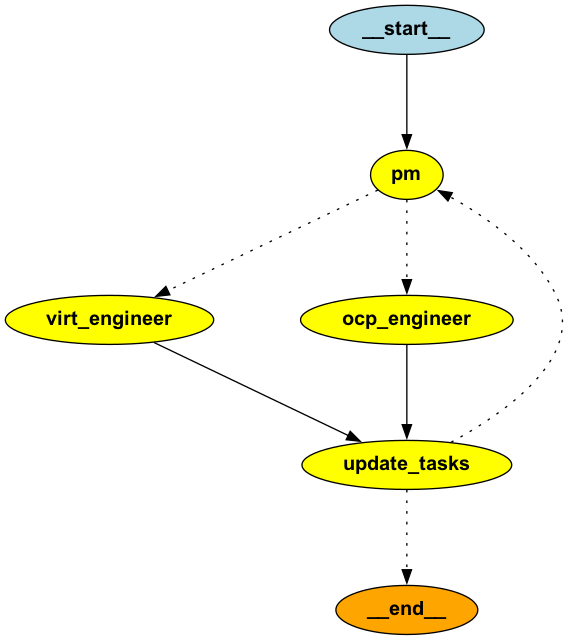

In [12]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_png()))
except ImportError:
    print(
        "You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt"
    )

In [13]:
# Define workflow parameters
iterations = 10
verbose = True

limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
for event in workflow.stream(dict_inputs, config):
    if verbose:
        print("\nEvent:", event)
    else:
        print("\n")

Tasks List -> [{'task_id': 'virt_task_1', 'description': "This is a single task! List all VMs. There's no need to retrieve any specific details. Just do this and nothing else! ", 'agent_name': 'virt_engineer', 'data': {}, 'status': 'pending'}, {'task_id': 'virt_task_2', 'description': 'List the details for the VM named: database-rmskd. Just do this and nothing else!', 'agent_name': 'virt_engineer', 'data': {}, 'status': 'pending'}, {'task_id': 'ocp_task_1', 'description': "Use the create_migration_plan_tool to create a migration plan named migration-plan for VM: database-rmskd. Don't do any additional steps!", 'agent_name': 'ocp_engineer', 'data': {}, 'status': 'pending'}, {'task_id': 'ocp_task_2', 'description': "Use the start_migration_plan_tool to start the migration plan named migration-plan. Don't do any additional steps!", 'agent_name': 'ocp_engineer', 'data': {}, 'status': 'pending'}]

Event: {'pm': None}
{'task_id': 'virt_task_1', 'description': "This is a single task! List all

/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


OpenShift Service connected. API is healthy.

1/8 Connected to Openshift...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



2/8 Now I have the source provider ID f0a9808a-ba6b-40a5-993f-d29e01b9ecc0...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



3/8 Now I have the host provider ID fd67dc37-90d7-4130-bbbb-2ac9948c65f0...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



4/8 Now I have the source network ID dvportgroup-1067...


5/8 Now I have all the VM Names and all the VM IDs []...

<|start_header_id|>ipython<|end_header_id|>

Failed to create migration plan: list index out of range<|eot_id|>
<|start_header_id|>ipython<|end_header_id|>

{
    "observation": "Failed to create migration plan: list index out of range"
}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>

{
    "thought": "The error indicates that there is an issue with the provided VM names or the order in which they are being processed. Since we want to migrate a single machine, let's try passing only one VM name.",
    "action": "create_migration_plan_tool",
    "action_input": {
        "vm_names": [
            "database-rmskd"
        ],
        "name": "migration-plan",
        "source": "vmware"
    }
}<|eot_id|>
<|python_tag|>create_migration_plan_tool.call({'vm_names': ['database-rmskd'], 'name': 'migration-plan', 'source': 'vmware'})
<|eom_id|>


/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


OpenShift Service connected. API is healthy.

1/8 Connected to Openshift...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



2/8 Now I have the source provider ID f0a9808a-ba6b-40a5-993f-d29e01b9ecc0...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



3/8 Now I have the host provider ID fd67dc37-90d7-4130-bbbb-2ac9948c65f0...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



4/8 Now I have the source network ID dvportgroup-1067...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



5/8 Now I have all the VM Names and all the VM IDs [{'id': 'vm-101923', 'name': 'database-rmskd'}]...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



5/8 Now I have the source datastore ID datastore-5031...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



7/8 Now I have the Storage and Network maps [{'id': 'vm-101923', 'name': 'database-rmskd'}]...



/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'forklift-inventory-openshift-mtv.apps.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ap


8/8 Migration plan RESPONSE - {'apiVersion': 'forklift.konveyor.io/v1beta1', 'kind': 'Plan', 'metadata': {'annotations': {'populatorLabels': 'True'}, 'creationTimestamp': '2024-09-17T12:42:15Z', 'generation': 1, 'managedFields': [{'apiVersion': 'forklift.konveyor.io/v1beta1', 'fieldsType': 'FieldsV1', 'fieldsV1': {'f:spec': {'.': {}, 'f:map': {'.': {}, 'f:network': {}, 'f:storage': {}}, 'f:provider': {'.': {}, 'f:destination': {}, 'f:source': {}}, 'f:targetNamespace': {}, 'f:vms': {}}}, 'manager': 'OpenAPI-Generator', 'operation': 'Update', 'time': '2024-09-17T12:42:15Z'}], 'name': 'migration-plan', 'namespace': 'openshift-mtv', 'resourceVersion': '2099294', 'uid': '535dfae2-7b00-4316-9458-bcdfabc2e0c8'}, 'spec': {'map': {'network': {'apiVersion': 'forklift.konveyor.io/v1beta1', 'kind': 'NetworkMap', 'name': 'vmware-wmzms', 'namespace': 'openshift-mtv', 'uid': 'a3c73cc9-a034-46f8-bef0-6deca687e289'}, 'storage': {'apiVersion': 'forklift.konveyor.io/v1beta1', 'kind': 'StorageMap', 'name

/Users/gsampaio/redhat/ai/virt-llm-agents/.conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.rosa-rmskd.5tw0.p1.openshiftapps.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


OpenShift Service connected. API is healthy.

1/4 Connected to Openshift...


2/4 Retrieved migration plan UID: 535dfae2-7b00-4316-9458-bcdfabc2e0c8...


3/4 Migration plan is ready. Starting migration...


4/4 Migration started: {'apiVersion': 'forklift.konveyor.io/v1beta1', 'kind': 'Migration', 'metadata': {'creationTimestamp': '2024-09-17T12:42:27Z', 'generateName': 'migration-plan-', 'generation': 1, 'managedFields': [{'apiVersion': 'forklift.konveyor.io/v1beta1', 'fieldsType': 'FieldsV1', 'fieldsV1': {'f:metadata': {'f:generateName': {}, 'f:ownerReferences': {'.': {}, 'k:{"uid":"535dfae2-7b00-4316-9458-bcdfabc2e0c8"}': {}}}, 'f:spec': {'.': {}, 'f:plan': {}}}, 'manager': 'python-requests', 'operation': 'Update', 'time': '2024-09-17T12:42:27Z'}], 'name': 'migration-plan-qbnj7', 'namespace': 'openshift-mtv', 'ownerReferences': [{'apiVersion': 'forklift.konveyor.io/v1beta1', 'kind': 'Plan', 'name': 'migration-plan', 'uid': '535dfae2-7b00-4316-9458-bcdfabc2e0c8'}], 'resourceVersion': 